In [1]:
import os
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Giving the initial data path

In [2]:
DATA_PATH = "learning_traces.13m.csv" 

Mapping some columns

In [3]:
COLUMN_MAP = {
    "user_id": ["user_id", "uid", "userId"],
    "lexeme_string": ["lexeme_string", "lexeme", "word", "token", "lexemeString"],
    "timestamp": ["timestamp", "time", "ts", "datetime"],
    "session_seen": ["session_seen", "seen_in_session", "n_seen_session", "seen"],
    "session_correct": ["session_correct", "correct_in_session", "n_correct_session", "correct"],
    "p_recall": ["p_recall", "precision", "recall_ratio", "pRecall"]
}

The threshold `MIN_COUNT = 30` is applied to exclude words or users that were seen fewer than 30 times. This helps ensure the recall rate metric is statistically stable and not dominated by outliers or random chance.

In [10]:
MIN_COUNT = 30

Reading the file

In [4]:
if not os.path.exists(DATA_PATH):
    raise FileNotFoundError(
        f"Couldn't find file at {DATA_PATH}. Upload it or fix DATA_PATH."
    )


In [5]:
df = pd.read_csv(DATA_PATH, low_memory=False)
print("Loaded shape:", df.shape)
print("Columns:", list(df.columns))

Loaded shape: (12854226, 12)
Columns: ['p_recall', 'timestamp', 'delta', 'user_id', 'learning_language', 'ui_language', 'lexeme_id', 'lexeme_string', 'history_seen', 'history_correct', 'session_seen', 'session_correct']


This block standardizes column names and automatically maps them to the expected fields (user, word, timestamp, etc.). It makes the script flexible to handle different versions of the Duolingo dataset where column names might vary (for example, "UserID", "user_id", or "uid"). If one of the key columns is missing, the code raises an error to prevent incorrect metric computation.

In [6]:
cols_lower = {c: c.strip().lower() for c in df.columns}
df.rename(columns=cols_lower, inplace=True)

def pick_col(candidates):
    """Return the first existing column from candidates (case-insensitive)."""
    for cand in candidates:
        cl = cand.lower()
        if cl in df.columns:
            return cl
    return None

col_user   = pick_col(COLUMN_MAP["user_id"])
col_lexeme = pick_col(COLUMN_MAP["lexeme_string"])
col_ts     = pick_col(COLUMN_MAP["timestamp"])
col_seen   = pick_col(COLUMN_MAP["session_seen"])
col_corr   = pick_col(COLUMN_MAP["session_correct"])
col_prec   = pick_col(COLUMN_MAP["p_recall"])

required = [col_user, col_lexeme, col_seen]
if any(c is None for c in required):
    missing = ["user_id", "lexeme_string", "session_seen"]
    raise ValueError(
        f"Missing one of the required columns (user, word, seen). "
        f"Found mapping: user={col_user}, lexeme={col_lexeme}, seen={col_seen}. "
        f"Edit COLUMN_MAP to match your CSV."
    )

- We filter out rows where `session_seen < 1` since they represent invalid or incomplete attempts. 
- Numeric conversion ensures all values can be safely used in calculations. 
- If the dataset lacks a direct `p_recall` column, we compute it using `session_correct / session_seen`. 
- The final check guarantees that recall data is available before continuing; otherwise, the script raises an error to prevent incorrect metric computation.


In [7]:
df = df[df[col_seen].fillna(0) >= 1].copy()

# Some datasets store totals; ensure integer-ish
df[col_seen] = pd.to_numeric(df[col_seen], errors="coerce")
if col_corr is not None:
    df[col_corr] = pd.to_numeric(df[col_corr], errors="coerce")

# If p_recall missing but we have correct & seen, derive p_recall = correct/seen
if col_prec is None and col_corr is not None:
    col_prec = "p_recall_computed"
    df[col_prec] = np.where(df[col_seen] > 0, df[col_corr] / df[col_seen], np.nan)

# Drop rows with no usable recall info
if col_prec is None and col_corr is None:
    raise ValueError(
        "No 'p_recall' and no (session_correct, session_seen) to compute it. "
        "Please update COLUMN_MAP to point to the right columns."
    )


- `first_attempt_mask` marks all rows where `session_seen == 1`, meaning the learner saw the word for the first time in that session.
-  `first_attempt_correct` marks those rows where the first attempt was answered correctly:
- If `p_recall` is available, we use `p_recall >= 0.999999` to account for floating-point precision.
- Otherwise, we use `session_correct >= 1` as a fallback.
- We then keep only these “first-attempt” rows (`df_first`) as the base dataset for computing the Recall Rate (First Attempt) metric.

This ensures the metric truly reflects memory retention between sessions, not short-term repetition within the same lesson.


In [ ]:
first_attempt_mask = (df[col_seen] == 1)

if col_prec is not None:
    # Handle floating precision around 1.0 (e.g., 0.999999)
    df["first_attempt_correct"] = first_attempt_mask & (df[col_prec] >= 0.999999)
else:
    # Fall back to discrete counts
    df["first_attempt_correct"] = first_attempt_mask & (df[col_corr] >= 1)

# Keep only first-attempt rows in the denominator for this metric
df_first = df[first_attempt_mask].copy()


In [17]:
grp_word = (
    df_first
    .groupby(col_lexeme, as_index=False)
    .agg(
        total_first_attempts=("first_attempt_correct", "size"),
        correct_first_attempts=("first_attempt_correct", "sum")
    )
)
grp_word["recall_rate_first_attempt"] = grp_word["correct_first_attempts"] / grp_word["total_first_attempts"]

# Apply stability filter
grp_word_stable = grp_word[grp_word["total_first_attempts"] >= MIN_COUNT].sort_values(
    "recall_rate_first_attempt", ascending=True
)

print("\nWord-level (stable) shape:", grp_word_stable.shape)
grp_word_stable.head(3)


Word-level (stable) shape: (8328, 4)


,lexeme_string,total_first_attempts,correct_first_attempts,recall_rate_first_attempt
15620,soeben/soeben<preadv>,31,9,0.290323
12521,more/more<n><sg>,47,18,0.382979
17342,vorne/vorne<adv>,30,12,0.400000


Code Summary
This block groups the filtered dataset by each unique word (`lexeme_string`) and calculates:
- **total_first_attempts:** how many times each word was encountered for the first time.
- **correct_first_attempts:** how many of those first attempts were answered correctly.
- **recall_rate_first_attempt:** the ratio of correct first attempts to total first attempts.

Then, a stability filter (`MIN_COUNT = 30`) is applied to keep only words with enough data for reliable statistics.  
Finally, the words are sorted by their recall rate in ascending order, showing the least remembered (hardest) words first.


In [18]:
grp_user = (
    df_first
    .groupby(col_user, as_index=False)
    .agg(
        total_first_attempts=("first_attempt_correct", "size"),
        correct_first_attempts=("first_attempt_correct", "sum")
    )
)
grp_user["user_recall_rate_first_attempt"] = grp_user["correct_first_attempts"] / grp_user["total_first_attempts"]

grp_user_stable = grp_user[grp_user["total_first_attempts"] >= MIN_COUNT].sort_values(
    "user_recall_rate_first_attempt", ascending=True
)

print("\nUser-level (stable) shape:", grp_user_stable.shape)
grp_user_stable.head(3)



User-level (stable) shape: (39344, 4)


,user_id,total_first_attempts,correct_first_attempts,user_recall_rate_first_attempt
37106,u:hCFg,116,18,0.155172
9563,u:dg7U,143,27,0.188811
41605,u:hTtE,176,45,0.255682


Output Interpretation
The printed table shows a preview of the word-level recall rates after filtering.  
Each row represents a unique word (or lexeme) with:
- `total_first_attempts`: how many users saw the word for the first time.
- `correct_first_attempts`: how many of those were recalled correctly.
- `recall_rate_first_attempt`: the computed success ratio on first attempts.

For example:
- `soeben/soeben<preadv>` → recall rate ≈ 0.29 (hard to recall)
- `more/more<n><sg>` → recall rate ≈ 0.38  
- `vorne/vorne<adv>` → recall rate ≈ 0.40  

The total shape `(8328, 4)` means 8,328 words met the stability threshold and were included in the analysis.


In [13]:
global_mean = grp_word_stable["recall_rate_first_attempt"].mean()
global_median = grp_word_stable["recall_rate_first_attempt"].median()
print(f"\nGlobal (word-level, stable) Average Recall Rate (First Attempt): {global_mean:.2%}")
print(f"Global (word-level, stable) Median Recall Rate (First Attempt):  {global_median:.2%}")


Global (word-level, stable) Average Recall Rate (First Attempt): 87.31%
Global (word-level, stable) Median Recall Rate (First Attempt):  88.51%


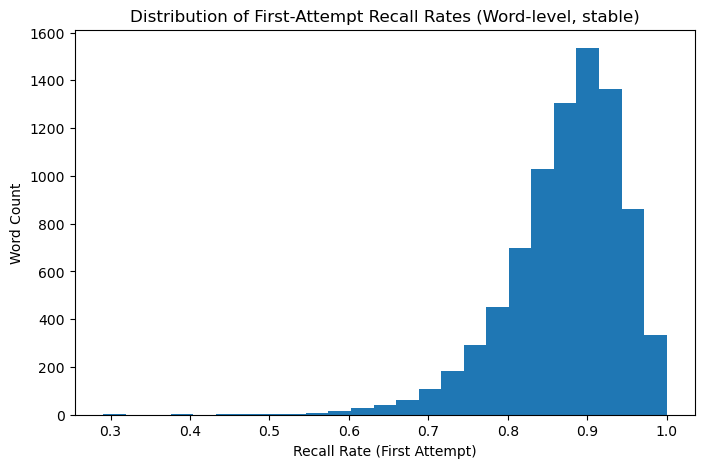

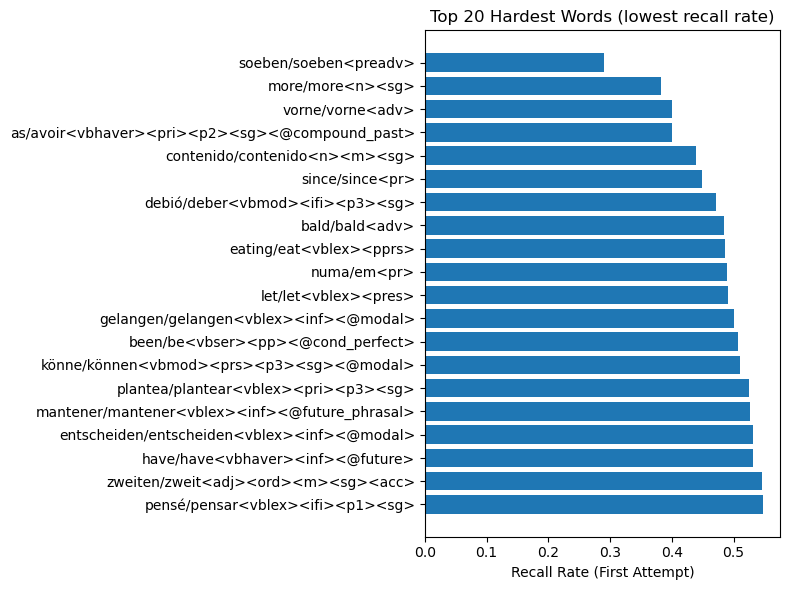

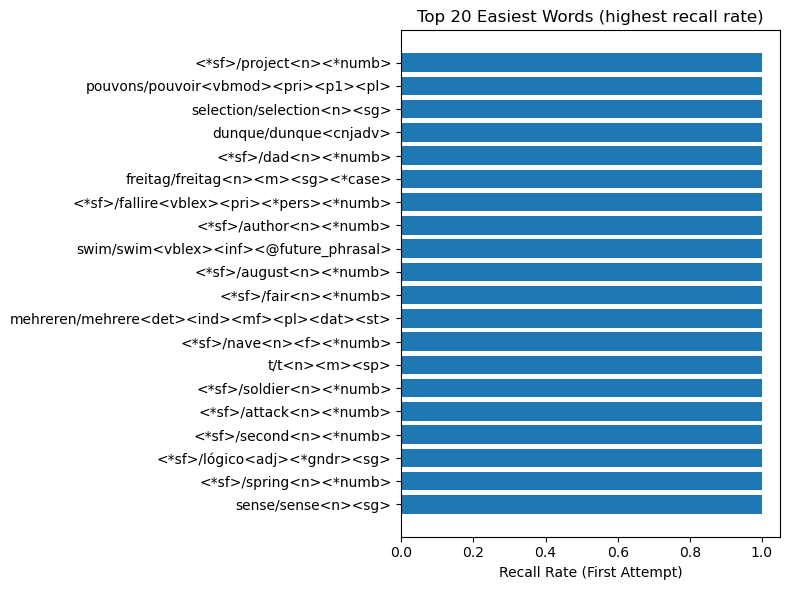

In [20]:
plt.figure(figsize=(8,5))
plt.hist(grp_word_stable["recall_rate_first_attempt"].dropna(), bins=25)
plt.xlabel("Recall Rate (First Attempt)")
plt.ylabel("Word Count")
plt.title("Distribution of First-Attempt Recall Rates (Word-level, stable)")
plt.savefig("images/recall_rate_distribution.png")
plt.show()

# Top 20 hardest / easiest words
top_n = 20
hardest = grp_word_stable.nsmallest(top_n, "recall_rate_first_attempt")
easiest = grp_word_stable.nlargest(top_n, "recall_rate_first_attempt")

plt.figure(figsize=(8,6))
plt.barh(hardest[col_lexeme], hardest["recall_rate_first_attempt"])
plt.xlabel("Recall Rate (First Attempt)")
plt.title(f"Top {top_n} Hardest Words (lowest recall rate)")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig("images/top_hardest_words.png")
plt.show()

plt.figure(figsize=(8,6))
plt.barh(easiest[col_lexeme], easiest["recall_rate_first_attempt"])
plt.xlabel("Recall Rate (First Attempt)")
plt.title(f"Top {top_n} Easiest Words (highest recall rate)")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


In [15]:
OUT_DIR = "./recall_rate_outputs"
os.makedirs(OUT_DIR, exist_ok=True)

grp_word.to_csv(os.path.join(OUT_DIR, "word_recall_rates_all.csv"), index=False)
grp_word_stable.to_csv(os.path.join(OUT_DIR, "word_recall_rates_stable.csv"), index=False)
grp_user.to_csv(os.path.join(OUT_DIR, "user_recall_rates_all.csv"), index=False)
grp_user_stable.to_csv(os.path.join(OUT_DIR, "user_recall_rates_stable.csv"), index=False)

print(f"\nSaved CSVs to: {os.path.abspath(OUT_DIR)}")



Saved CSVs to: /Users/admin/Desktop/internship_tasks/recall_rate_outputs


In [16]:
def wilson_interval(k, n, z=1.96):
    if n == 0:
        return (np.nan, np.nan)
    phat = k / n
    denom = 1 + (z**2)/n
    center = (phat + (z**2)/(2*n)) / denom
    margin = (z * math.sqrt((phat*(1-phat)/n) + (z**2)/(4*n*n))) / denom
    return (center - margin, center + margin)

ci_low, ci_high = [], []
for k, n in zip(grp_word_stable["correct_first_attempts"], grp_word_stable["total_first_attempts"]):
    lo, hi = wilson_interval(k, n, 1.96)
    ci_low.append(lo); ci_high.append(hi)

grp_word_stable["recall_rate_ci_low"] = ci_low
grp_word_stable["recall_rate_ci_high"] = ci_high

grp_word_stable.to_csv(os.path.join(OUT_DIR, "word_recall_rates_stable_with_ci.csv"), index=False)
print("Added Wilson 95% CI and saved: word_recall_rates_stable_with_ci.csv")

Added Wilson 95% CI and saved: word_recall_rates_stable_with_ci.csv
